In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
import requests
from pyproj import Proj, transform
import tqdm
import concurrent.futures
import requests
import time
import shapefile
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import geopandas
import fiona
import rtree

# Load data

In [134]:
boucherville_2013 = pd.read_csv("data/OD13_amtSm_309.csv")
longueuilEst_2013 = pd.read_csv("data/OD13_amtSm_302.csv")
saintBruno_2013 = pd.read_csv("data/OD13_amtSm_310.csv")
#suburb = pd.concat([boucherville_2013, longueuilEst_2013, saintBruno_2013])
suburb_2013 = pd.read_csv("data/OD13_suburb_with_walkscore_and_trip_osrm.csv")
suburb_2013.title = "Banlieue 2013"

boucherville_2003 = pd.read_csv("data/OD03_amtSm_309.csv")
longueuilEst_2003 = pd.read_csv("data/OD03_amtSm_302.csv")
saintBruno_2003 = pd.read_csv("data/OD03_amtSm_310.csv")
#suburb_2003 = pd.concat([boucherville_2003, longueuilEst_2003, saintBruno_2003])
suburb_2003 = pd.read_csv("data/OD03_suburb_with_od_trips.csv")
suburb_2003.title = "Banlieue 2003"

#montrealNord = pd.read_csv("data/OD13_amtSm_118.csv")
montrealNord = pd.read_csv("data/OD13_montrealNord_od_trips.csv")
montrealNord.title = "Montréal-Nord"

#plateau = pd.read_csv("data/OD13_amtSm_106.csv")
plateau = pd.read_csv("data/OD13_plateau_with_od_trips.csv")
plateau.title = "Le Plateau Mont-Royal"

EPOI_2013_Boucherville = pd.read_csv("data/EPOI2013Sm_309.csv")

da_density = pd.read_csv("data/T1901EN.CSV", encoding="cp1252", usecols=["Geographic code", "Population density per square kilometre, 2016"])
da_density.columns = ['geographic_code', 'density']
da_density.set_index('geographic_code', inplace=True)

da_shapefile = fiona.open('data/lda_000b16a_e.shp')


In [153]:
# Create the R-tree index and store the features in it (bounding box)
spatial_index = rtree.index.Index()
for pos, poly in tqdm.tqdm(enumerate(da_shapefile)):
    spatial_index.insert(pos, shape(poly['geometry']).bounds)

56589it [00:20, 2822.45it/s]


In [4]:
# NAD 83 to lat long
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:32188", "epsg:4326", always_xy=True)

## WalkScore

In [5]:
exit_early = True

In [6]:
def load_url(url, feuillet_id, timeout=20):
    ans = requests.get(url, timeout=timeout)
    json_output = ans.json()
    #json_output = {"walkscore": feuillet_id}
    return feuillet_id, ans, json_output

def calculate_walk_score(df, exit_early=True):
    futures = []
    
    if exit_early:
        return
    warning = input("Warning!!! Are you sure ? ").lower()

    if warning != "y":
        print("bye")
        return

    feuillet_ids = df.feuillet.unique()
    with tqdm.tqdm(total=len(feuillet_ids)) as progress_bar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=9) as executor:
            for feuillet_id in feuillet_ids:                
                x_domi = (df[df.feuillet == feuillet_id].xdomi).iloc[0]
                y_domi = (df[df.feuillet == feuillet_id].ydomi).iloc[0]
                x_domi, y_domi = transformer.transform(int(x_domi), int(y_domi))
                rows = df[df.feuillet == feuillet_id]
                url = f"https://api.walkscore.com/score?format=json&transit=1&bike=1&lon={x_domi}&lat={y_domi}&wsapikey=2845bc34690754d7389df25eabeb8ce9"
                #url = "https://jsonplaceholder.typicode.com/todos/1"
                futures.append(executor.submit(load_url, url, feuillet_id))

            for future in concurrent.futures.as_completed(futures):
                feuillet_id, ans, json_resp = future.result()
                if ans.status_code != 200:
                    print(f"{feuillet_id}, {json_resp}")

                walk_score = json_resp.get("walkscore", -1)
                bike_score = json_resp.get("bike", {}).get("score", -1)
                transit_score = json_resp.get("transit", {}).get("score", -1)

                # Store the data
                df.loc[df.feuillet == feuillet_id, 'walkscore'] = walk_score
                df.loc[df.feuillet == feuillet_id, 'bikescore'] = bike_score
                df.loc[df.feuillet == feuillet_id, 'transitscore'] = transit_score

                progress_bar.update(1)


In [7]:
calculate_walk_score(suburb_2013, exit_early=exit_early)
#suburb.to_csv("data/OD13_suburb_with_walkscore.csv")

In [8]:
calculate_walk_score(montrealNord, exit_early=exit_early)
#montrealNord.to_csv("data/OD13_montrealNord_with_walkscore.csv")

In [9]:
calculate_walk_score(plateau, exit_early=exit_early)
#plateau.to_csv("data/OD13_plateau_with_walkscore.csv")

# Trip lengths (OSRM)

In [299]:
def load_url_osrm(url, ipere, timeout=20):
    ans = requests.get(url, timeout=timeout)
    json_output = ans.json()
    return ipere, ans, json_output


def calculate_trip_length(df, exit_early=True):
    futures = []
    
    if exit_early:
        return
    warning = input("Warning!!! Are you sure ? ").lower()

    if warning != "y":
        print("bye")
        return

    with tqdm.tqdm(total=len(df)) as progress_bar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=9) as executor:
            for i, row in df.iterrows():

                x_orig, y_orig = transformer.transform(int(row.xorig), int(row.yorig))
                x_dest, y_dest = transformer.transform(int(row.xdest), int(row.ydest))

                url = f"http://localhost:5000/route/v1/driving/{x_orig},{y_orig};{x_dest},{y_dest}?overview=false&geometries=geojson"
                futures.append(executor.submit(load_url_osrm, url, row.ipere))

            for future in concurrent.futures.as_completed(futures):
                ipere, ans, json_resp = future.result()
                #print(json_resp)
                if ans.status_code != 200 or json_resp['code'] != "Ok":
                    print(f"{ipere}, {json_resp}")
                #print(json_resp)
                distance_meters = json_resp['routes'][0]['distance']
                duration_seconds = json_resp['routes'][0]['duration']
                
                df.loc[df.ipere == ipere, 'distance_meters'] = distance_meters
                df.loc[df.ipere == ipere, 'duration_seconds'] = duration_seconds

                # Store the data
                #df.loc[df.feuillet == feuillet_id, 'walkscore'] = walk_score
                #df.loc[df.feuillet == feuillet_id, 'bikescore'] = bike_score
                #df.loc[df.feuillet == feuillet_id, 'transitscore'] = transit_score

                progress_bar.update(1)



In [300]:
#calculate_trip_length(suburb_2013, exit_early=False)
#suburb_2013.to_csv("data/OD13_suburb_with_walkscore_and_trip_osrm.csv")
#calculate_trip_length(suburb_2003, exit_early=False)
#suburb_2003.to_csv("data/OD03_suburb_with_od_trips.csv")
#calculate_trip_length(plateau, exit_early=False)
#plateau.to_csv("data/OD13_plateau_with_odtrips.csv")
#calculate_trip_length(montrealNord, exit_early=False)
#montrealNord.to_csv("data/OD13_montrealNord_with_odtrips.csv")

Warning!!! Are you sure ? y


100%|████████████████████████████████████| 10369/10369 [01:07<00:00, 154.74it/s]


Warning!!! Are you sure ? y


100%|██████████████████████████████████████| 7659/7659 [00:44<00:00, 172.25it/s]


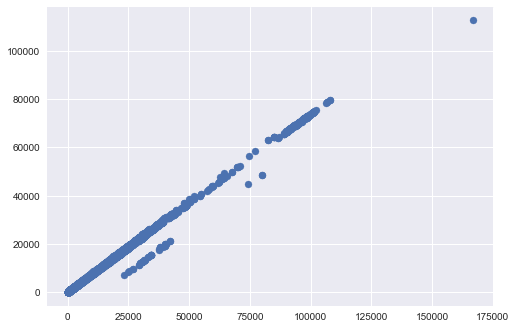

In [540]:
plt.scatter(suburb_2013.distance_meters, suburb_2013.duration_seconds)

# Densities

In [541]:
def calculate_density(df):
    transformer2 = Transformer.from_crs("epsg:32188", "epsg:3347", always_xy=True)
    households = df[df.f_menage == "T"]
    for i, row in tqdm.tqdm(households.iterrows()):
        point = Point(transformer2.transform(row.xdomi, row.ydomi))
        for j in spatial_index.intersection(point.coords[0]):
            if point.within(shape(da_shapefile[j]['geometry'])):
                dauid = int(da_shapefile[j]['properties']['DAUID'])
                density = da_density.loc[dauid][0]
                df.loc[df.feuillet == row.feuillet, 'density'] = density
                break
        else:
            print("could not find")

In [542]:
calculate_density(suburb_2013)
calculate_density(suburb_2003)
calculate_density(montrealNord)
calculate_density(plateau)

2366it [00:05, 450.32it/s]
1897it [00:02, 761.72it/s]
1475it [00:01, 856.23it/s]
1946it [00:02, 780.71it/s]


# Typologies

## Personnes

In [543]:
def pers_typology(df, typology_number):
    if typology_number == 1:   # Typologie 1: femmes, 20-39 ans, étudiantes
        return df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 3)]
    elif typology_number == 2: # Typologie 2: femmes, 20-39 ans, travailleuses à temps plein
        return df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 1)]
    elif typology_number == 3: # Typologie 3: hommes, 20-39 ans, étudiants
        return df[(df.genre == 1) 
            & (df.age >= 20) 
            & (df.age <= 39)
            & (df.p_statut == 3)]
    elif typology_number == 4: # Typologie 4: hommes, 20-39 ans, travailleurs à temps plein
        return df[(df.genre == 1) 
            & (df.age >= 20) 
            & (df.age <= 39)
            & (df.p_statut == 1)]
    elif typology_number == 5: # Typologie 5: Hommes, 50-69 ans, retraités
        return df[(df.genre == 1) 
            & (df.age >= 50) 
            & (df.age <= 69)
            & (df.p_statut == 4)]
    elif typology_number == 6: # Typologie 6: Hommes, 50-69 ans, travailleurs à temps plein
        return df[(df.genre == 1) 
            & (df.p_statut == 1)
            & (df.age >= 50) 
            & (df.age <= 69)
        ]

In [544]:
def calculate_pers_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the people DB
    df_ = df[df["f_pers"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6]:
        facper_share = pers_typology(df_, i).facper.sum() / df_.facper.sum()
        df_typology = pers_typology(df_, i)
        print(f"Typologie {i}: {len(df_typology)}, {(len(df_typology) / len(df_)) * 100:0.2f}%, facper: {facper_share * 100:0.2f} %")

In [545]:
calculate_pers_typology_obs_size(suburb_2013)
calculate_pers_typology_obs_size(suburb_2003)
calculate_pers_typology_obs_size(montrealNord)
calculate_pers_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 108, 1.86%, facper: 2.33 %
Typologie 2: 288, 4.96%, facper: 6.66 %
Typologie 3: 116, 2.00%, facper: 2.61 %
Typologie 4: 327, 5.63%, facper: 7.89 %
Typologie 5: 349, 6.01%, facper: 4.47 %
Typologie 6: 525, 9.04%, facper: 8.15 %
=== Banlieue 2003 ===
Typologie 1: 90, 1.91%, facper: 2.09 %
Typologie 2: 368, 7.82%, facper: 8.20 %
Typologie 3: 80, 1.70%, facper: 1.88 %
Typologie 4: 419, 8.90%, facper: 9.48 %
Typologie 5: 205, 4.36%, facper: 4.26 %
Typologie 6: 326, 6.93%, facper: 6.41 %
=== Montréal-Nord ===
Typologie 1: 83, 2.46%, facper: 3.06 %
Typologie 2: 151, 4.48%, facper: 5.52 %
Typologie 3: 51, 1.51%, facper: 2.13 %
Typologie 4: 202, 6.00%, facper: 7.89 %
Typologie 5: 139, 4.13%, facper: 3.15 %
Typologie 6: 194, 5.76%, facper: 5.18 %
=== Le Plateau Mont-Royal ===
Typologie 1: 127, 3.24%, facper: 6.01 %
Typologie 2: 318, 8.10%, facper: 12.76 %
Typologie 3: 114, 2.91%, facper: 4.66 %
Typologie 4: 385, 9.81%, facper: 16.34 %
Typologie 5: 165, 4.20%, f

In [597]:
def add_convex_hull(df):
    df["person_id"] = df['feuillet'].astype(str) + "_" + df['rang'].astype(str)
    for person_id in tqdm.tqdm(df.person_id.unique()):
        trips = df[df.person_id == person_id]

        points = []
        for i, row in trips.iterrows():
            points.append(Point((row.xorig, row.yorig)))
            points.append(Point((row.xdest, row.ydest)))
            
        convex_hull = shapely.geometry.MultiPoint(points).convex_hull
        df.loc[df.person_id == person_id, 'ch_area'] = convex_hull.area
        df.loc[df.person_id == person_id, 'ch_perimeter'] = convex_hull.length
        df.loc[df.person_id == person_id, 'ch'] = convex_hull.wkt
        
for df in [suburb_2013, montrealNord, plateau]:
    add_convex_hull(df)

100%|██████████████████████████████████████| 3924/3924 [00:23<00:00, 170.09it/s]


In [580]:
suburb_2013

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ipere,feuillet,rang,ch_id,sdomi100,xdomi,ydomi,...,transitscore,children,drivers,retired,trip_distance,distance_meters,duration_seconds,density,age_cut,person_id
0,0,0,0,428,1000265,1,1.0,309,309320,5050582,...,-1.0,0,1,0,10461.037903,13517.7,9976.4,3254.0,"(30, 35]",1000265_1
1,1,1,1,429,1000265,1,1.0,309,309320,5050582,...,-1.0,0,1,0,10461.037903,13517.7,9976.4,3254.0,"(30, 35]",1000265_1
2,2,2,2,470,1000282,1,1.0,309,310817,5051267,...,-1.0,2,2,0,1137.763156,1228.7,900.9,1692.1,"(35, 40]",1000282_1
3,3,3,3,471,1000282,1,1.0,309,310817,5051267,...,-1.0,2,2,0,765.204548,983.2,717.1,1692.1,"(35, 40]",1000282_1
4,4,4,4,472,1000282,1,1.0,309,310817,5051267,...,-1.0,2,2,0,508.338470,611.0,447.7,1692.1,"(35, 40]",1000282_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,14537,14537,2699,451945,9019168,1,3.0,310,315842,5043768,...,-1.0,0,1,0,15945.997680,20380.9,15039.9,2519.6,"(55, 60]",9019168_1
14538,14538,14538,2700,452178,9022528,1,1.0,310,316742,5039585,...,-1.0,0,2,0,35387.181648,39074.0,28971.7,404.8,"(20, 25]",9022528_1
14539,14539,14539,2701,452179,9022528,1,1.0,310,316742,5039585,...,-1.0,0,2,0,35387.181648,39074.0,28971.7,404.8,"(20, 25]",9022528_1
14540,14540,14540,2702,452180,9022528,2,1.0,310,316742,5039585,...,-1.0,0,2,0,35387.181648,39074.0,28971.7,404.8,"(60, 65]",9022528_2


In [603]:
geopd = geopandas.read_file('data/lda_000b16a_e.shp')

<Figure size 2400x2400 with 0 Axes>

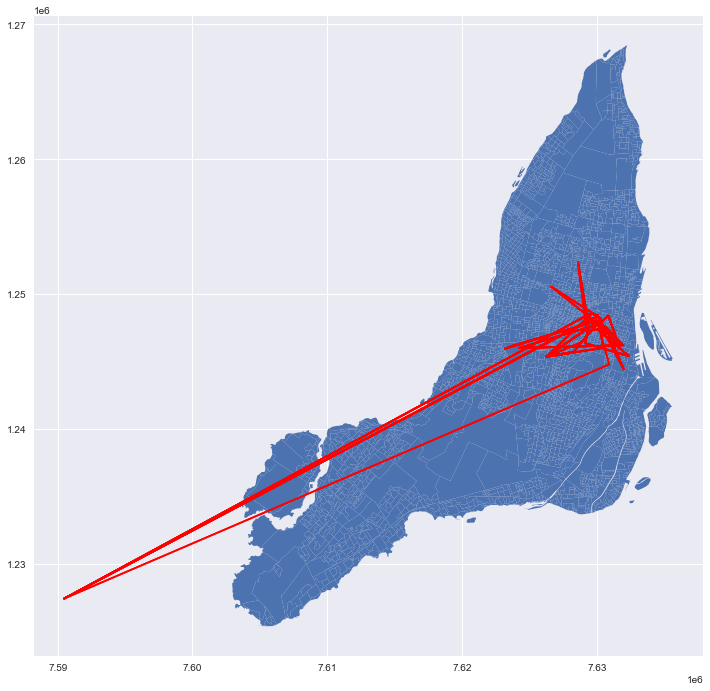

In [646]:
plt.figure(figsize=(12, 12), dpi=200)
geopd[(geopd.PRNAME == "Quebec / Québec") & (geopd.CCSNAME == "Montréal")].plot(figsize=(12, 12))
import shapely.wkt
tt2 = Transformer.from_crs("epsg:32188", "epsg:3347", always_xy=True)
for i in range(0, 120):
    try:
        x, y = shapely.wkt.loads(plateau.iloc[i].ch).exterior.xy
        x2 = []
        y2 = []
        for x_coord, y_coord in zip(x, y):
            x2.append(tt2.transform(x_coord, y_coord)[0])
            y2.append(tt2.transform(x_coord, y_coord)[1])
        plt.plot(np.array(x2), np.array(y2), "r")
    except AttributeError:
        pass

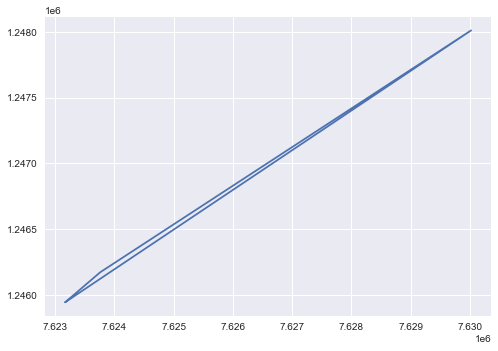

5043901.0

In [601]:
geopd.PRNAME.unique()

array(['Newfoundland and Labrador / Terre-Neuve-et-Labrador',
       'Prince Edward Island / Île-du-Prince-Édouard',
       'Nova Scotia / Nouvelle-Écosse',
       'New Brunswick / Nouveau-Brunswick', 'Quebec / Québec', 'Ontario',
       'Manitoba', 'Saskatchewan', 'Alberta',
       'British Columbia / Colombie-Britannique',
       'Northwest Territories / Territoires du Nord-Ouest', 'Nunavut',
       'Yukon'], dtype=object)

In [614]:
geopd[(geopd.PRNAME == "Quebec / Québec") & (geopd.CCSNAME == "Montréal")]

,DAUID,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,CSDUID,CSDNAME,...,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,CTUID,CTNAME,ADAUID,geometry
10079,24661006,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620092.00,0092.00,24660213,"POLYGON ((7631081.754 1238771.397, 7631233.543..."
10080,24661007,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620092.00,0092.00,24660213,"POLYGON ((7631098.286 1238390.403, 7631038.949..."
10081,24661008,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620092.00,0092.00,24660213,"POLYGON ((7630810.317 1238610.629, 7630868.189..."
10082,24661009,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620092.00,0092.00,24660213,"POLYGON ((7630913.634 1238280.943, 7630846.934..."
10083,24661010,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620092.00,0092.00,24660213,"POLYGON ((7630713.409 1238163.786, 7630646.814..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15404,24662574,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620278.00,0278.00,24660078,"POLYGON ((7622722.034 1248769.854, 7622717.986..."
15405,24662575,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620278.00,0278.00,24660078,"POLYGON ((7622760.649 1249148.823, 7622751.606..."
15406,24662576,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620278.00,0278.00,24660078,"POLYGON ((7622740.189 1248932.791, 7622735.337..."
15407,24662577,24,Quebec / Québec,2466,Montréal,TÉ,2466023,Montréal,2466023,Montréal,...,462,1,462,24462,Montréal,B,4620278.00,0278.00,24660078,"POLYGON ((7623023.600 1249121.623, 7623012.920..."


## Ménages

In [546]:
def add_children_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        children_count = len(people_in_household[people_in_household.age <= 17])
        df.loc[df.feuillet == feuillet_id, 'children'] = children_count
    df['children'] = df['children'].astype(int)
def add_drivers_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        drivers_count = len(people_in_household[people_in_household.permis == 1])
        df.loc[df.feuillet == feuillet_id, 'drivers'] = drivers_count

    df['drivers'] = df['drivers'].astype(int)
def add_retired_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        retired_count = len(people_in_household[people_in_household.p_statut == 4])
        df.loc[df.feuillet == feuillet_id, 'retired'] = retired_count
    df['retired'] = df['retired'].astype(int)

for df in tqdm.tqdm([suburb_2013, suburb_2003, montrealNord, plateau]):
    add_children_column(df)
    add_drivers_column(df)
    add_retired_column(df)
    #add_trip_distance_column(df)


100%|█████████████████████████████████████████████| 4/4 [00:37<00:00,  9.40s/it]


In [547]:
def menages_typology(df, typology):
    if typology == 1: # Typologie 1: min 1 enfant, pas d'automobiles
        return df[(df.children >= 1)
                & (df.autologi == 0)
                ]
    elif typology == 2: # Typologie 2: 4+ logis, 2 enfants+, 2 autos+
        return df[(df.perslogi >= 4)
                & (df.children >= 2)
                & (df.autologi >= 2)
                ]
    elif typology == 3: # Typologie 3: Full car access : Nb drivers = Nb automobiles
        return df[(df.autologi == df.drivers)
                & (df.autologi >= 1)
                ]
    elif typology == 4: # Typologie 4: More cars than drivers
        return df[(df.autologi > df.drivers)
                ]
    elif typology == 5: # Typologie 5: Couples sans enfants (ou colocataires)
        return df[(df.children == 0)
                & (df.perslogi == 2)
                ]
    elif typology == 6: # Typologie 6: Couple de retraités ayant chacun un permis de conduire
        return df[(df.perslogi == 2)
                & (df.retired == 2)
                & (df.drivers == 2)
                ]
    elif typology == 7: # Typologie 7: 4+ logis, 2 enfants+
        return df[(df.perslogi >= 4)
                & (df.children >= 2)
                ]

In [548]:
def calculate_household_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the household DB
    df_ = df[df["f_menage"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6, 7]:
        fshare = menages_typology(df_, i).faclog.sum() / df_.faclog.sum()
        print(f"Typologie {i}: {len(menages_typology(df_, i))} {round(fshare * 100, 2):0.2f} %")

In [549]:
calculate_household_typology_obs_size(suburb_2013)
calculate_household_typology_obs_size(montrealNord)
calculate_household_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 12 0.53 %
Typologie 2: 288 11.26 %
Typologie 3: 1415 60.96 %
Typologie 4: 146 6.39 %
Typologie 5: 989 35.21 %
Typologie 6: 352 11.59 %
Typologie 7: 369 14.15 %
=== Montréal-Nord ===
Typologie 1: 54 4.00 %
Typologie 2: 68 4.55 %
Typologie 3: 697 46.87 %
Typologie 4: 59 4.25 %
Typologie 5: 461 27.03 %
Typologie 6: 87 4.60 %
Typologie 7: 205 14.09 %
=== Le Plateau Mont-Royal ===
Typologie 1: 106 3.91 %
Typologie 2: 23 0.66 %
Typologie 3: 591 31.28 %
Typologie 4: 40 2.14 %
Typologie 5: 571 29.01 %
Typologie 6: 46 1.82 %
Typologie 7: 192 5.70 %


## Voisinages

count    32570.000000
mean      8932.534949
std       7037.247095
min          0.000000
25%       3022.700000
50%       6920.100000
75%      13984.700000
max      45392.900000
Name: density, dtype: float64

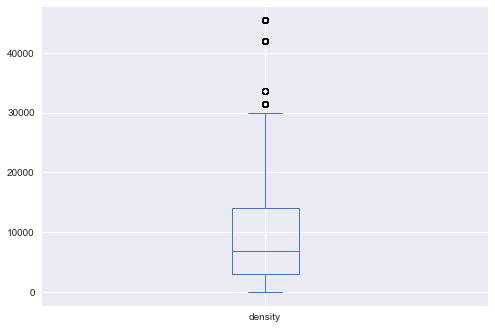

In [550]:
all_densities = pd.concat([suburb_2013.density, montrealNord.density, plateau.density])
all_densities.plot.box()
all_densities.describe()

count    32570.000000
mean        56.575100
std         28.836868
min          0.000000
25%         33.000000
50%         58.000000
75%         87.000000
max         98.000000
Name: walkscore, dtype: float64

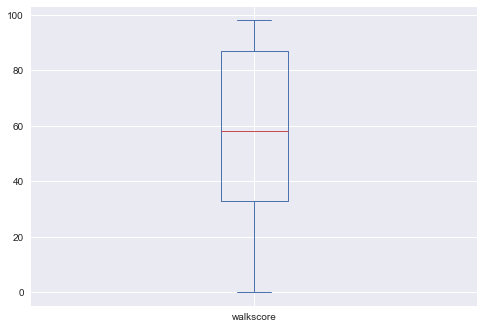

In [551]:
all_walkscores = pd.concat([suburb_2013.walkscore, montrealNord.walkscore, plateau.walkscore])
all_walkscores.plot.box()
all_walkscores.describe()

In [552]:
def neighborhood_typology(df, typology):
    if typology == 1: 
        return df[(df.walkscore < all_walkscores.quantile(.25))
                & (df.density < all_densities.quantile(.25))
                ]
    elif typology == 2:
        return df[(df.walkscore >= all_walkscores.quantile(.25))
                & (df.walkscore < all_walkscores.quantile(.50))
                & (df.density >= all_densities.quantile(.25))
                & (df.density < all_densities.quantile(.50))
                ]
    elif typology == 3:
        return df[(df.walkscore >= all_walkscores.quantile(.50))
                & (df.walkscore < all_walkscores.quantile(.75))
                & (df.density >= all_densities.quantile(.50))
                & (df.density < all_densities.quantile(.75))
                ]
    elif typology == 4:
        return df[(df.walkscore >= all_walkscores.quantile(.75))
                & (df.walkscore < all_walkscores.quantile(1))
                & (df.density >= all_densities.quantile(.75))
                & (df.density < all_densities.quantile(1))
                ]

In [553]:
def calculate_neighborhood_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the household DB
    df_ = df[df["f_menage"] == 'T']
    
    for i in [1, 2, 3, 4]:
        fshare = neighborhood_typology(df_, i).faclog.sum() / df_.faclog.sum()
        print(f"Typologie {i}: {len(menages_typology(df_, i))} {round(fshare * 100, 2):0.2f} %")

calculate_neighborhood_typology_obs_size(suburb_2013)
calculate_neighborhood_typology_obs_size(montrealNord)
calculate_neighborhood_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 12 31.38 %
Typologie 2: 288 15.83 %
Typologie 3: 1415 2.98 %
Typologie 4: 146 0.00 %
=== Montréal-Nord ===
Typologie 1: 54 0.00 %
Typologie 2: 68 13.96 %
Typologie 3: 697 29.32 %
Typologie 4: 59 0.00 %
=== Le Plateau Mont-Royal ===
Typologie 1: 106 0.00 %
Typologie 2: 23 0.00 %
Typologie 3: 591 5.89 %
Typologie 4: 40 51.22 %


# Tâche #2

[10.37767562 12.50983111 10.80142697 11.41497875 14.8633178  16.33509275
 12.60862259  8.20242312  2.6569537   0.22967758]
[11.05167269 13.84339846 11.78566454 13.66042676 18.88124172 14.66641621
  9.66614158  4.79089681  1.46936289  0.18477835]


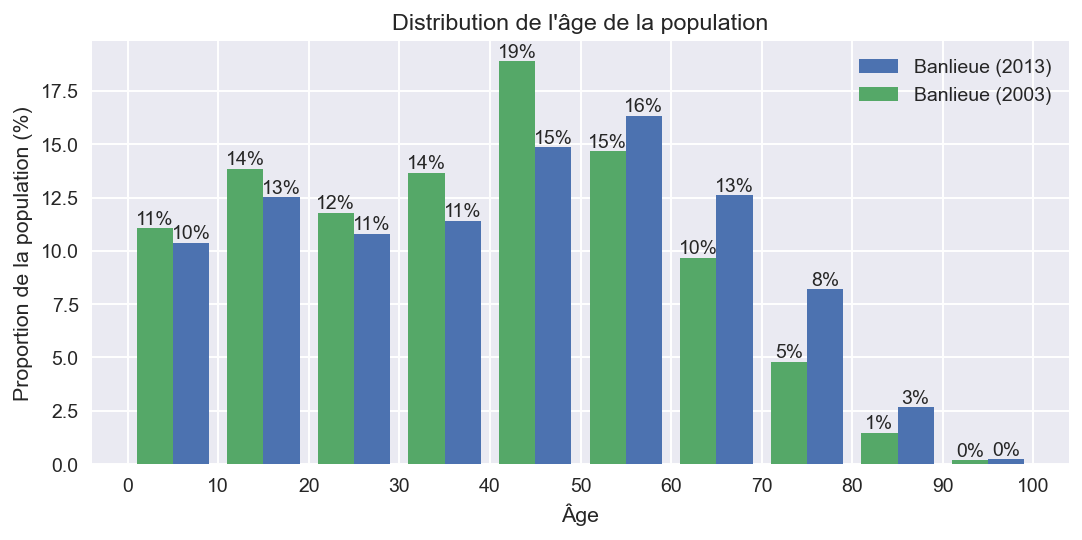

In [554]:
width = 4
plt.figure(figsize=(9, 4), dpi=140)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    age_bins = np.histogram(list(df_people.age), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    print(age_bins)
    
    bar = plt.bar(age_bin_edges[:-1]-offset+5, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(age_bin_edges)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'âge de la population")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()


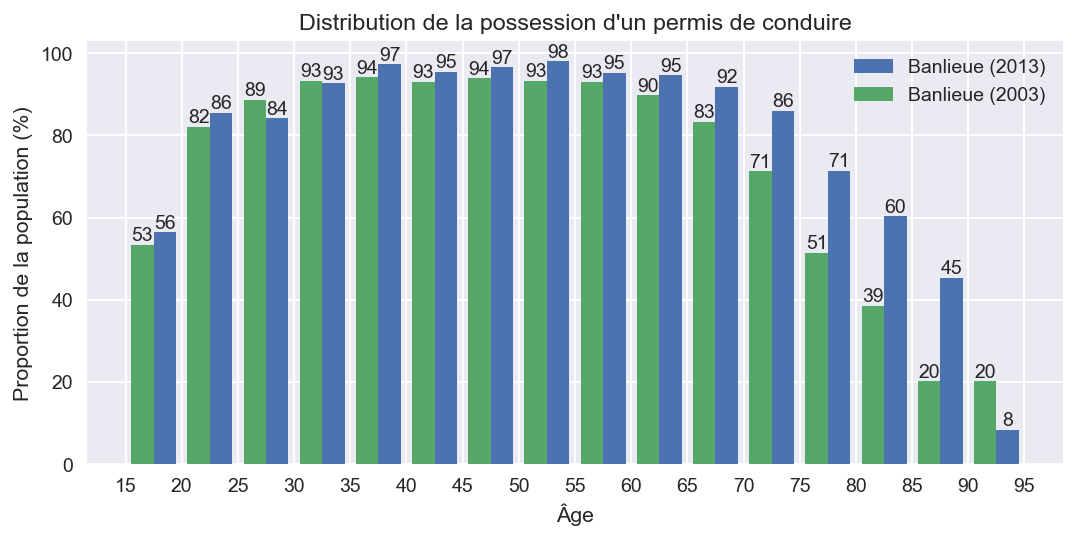

In [555]:
width = 2
plt.figure(figsize=(9, 4), dpi=140)
def drivers_plot(df, title, offset):
    bins = np.arange(15, 100, 5)
    df["age_cut"] = pd.cut(df["age"], bins)

    df_people = df[df["f_pers"] == 'T']
    drivers_rate = df_people[df_people["permis"] == 1].groupby("age_cut").sum()["facper"] / df_people.groupby("age_cut").sum()["facper"] * 100
    
    bar = plt.bar(bins[:-1]+2.5-offset, drivers_rate, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f")
    _ = plt.xticks(bins)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de la possession d'un permis de conduire")
drivers_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
drivers_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()


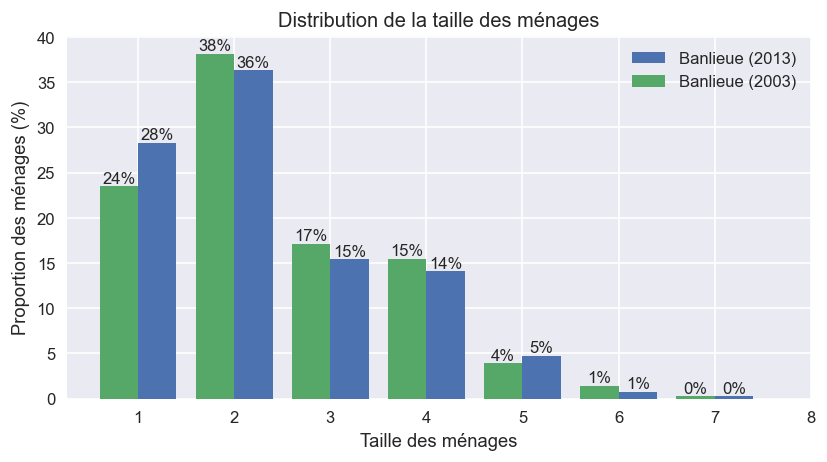

In [556]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    bins = np.histogram(list(df_households.perslogi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Taille des ménages")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution de la taille des ménages")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()



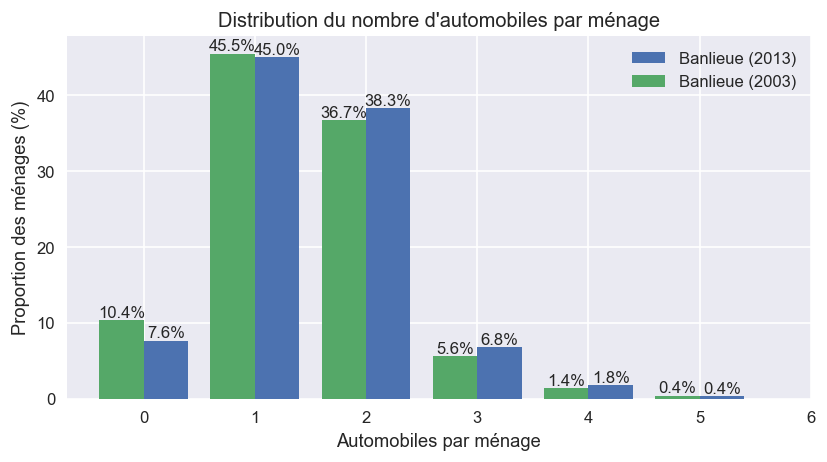

In [557]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_households.autologi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.1f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Automobiles par ménage")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par ménage")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()


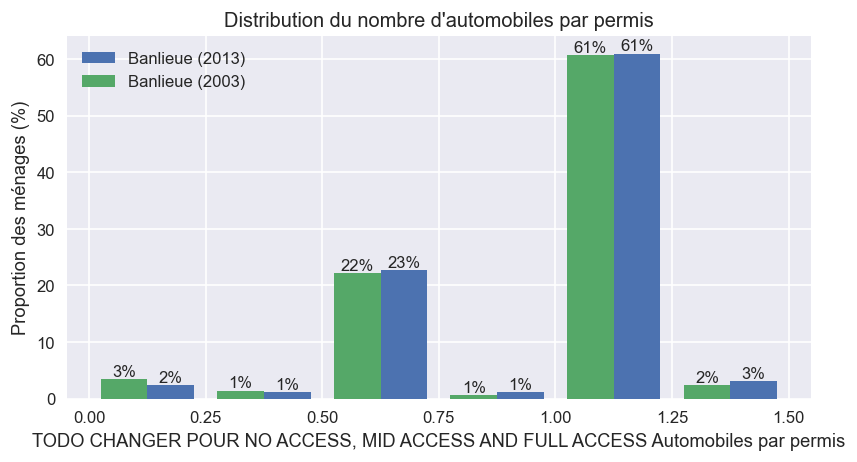

In [558]:
width = 0.10
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.5])
    bins = np.histogram(list(df_households.autologi / df_households.drivers), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset+0.125, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("TODO CHANGER POUR NO ACCESS, MID ACCESS AND FULL ACCESS Automobiles par permis")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par permis")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()



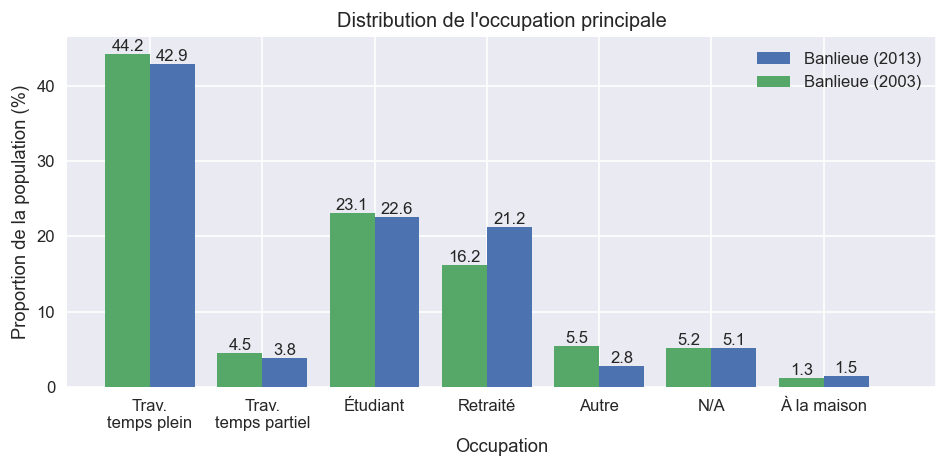

In [559]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    age_bins = np.histogram(list(df_people.p_statut), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    
    bar = plt.bar(age_bin_edges[:-1]-offset, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.1f")

    _ = plt.xticks(age_bin_edges, ["Trav.\ntemps plein", "Trav.\ntemps partiel", "Étudiant", "Retraité", "Autre", "N/A", "À la maison", ""])
    plt.xlabel("Occupation")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'occupation principale")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()



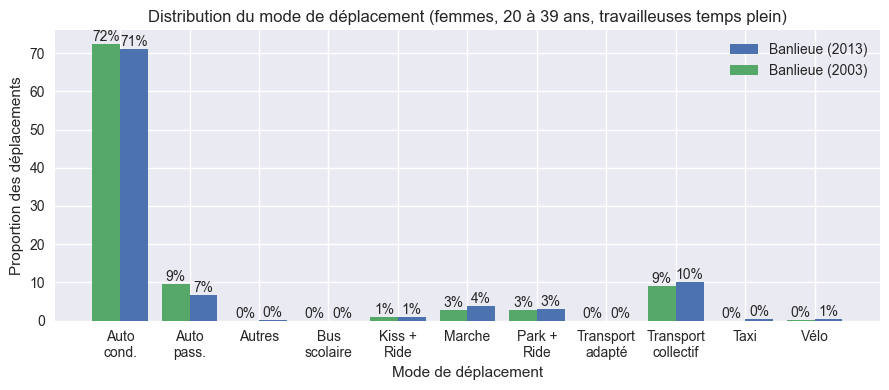

In [560]:
width = 0.4
plt.figure(figsize=(9, 4), dpi=100)
def _plot(df, title, offset):
    #df_chaines = df[df["f_chaine"] == 'T']
    df_chaines = df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 1)]
    
    total_facper = df_chaines.facper.sum()

    modes_ = (df_chaines.groupby("mode").sum()["facper"] / total_facper.sum() * 100)
    modes = []
    for mode in ["AC", "AP", "AUTRES", "BS", "KR", "MARCHE", "PR", "TA", "TC", "TX", "VELO"]:
        try:
            modes.append(modes_[mode])
        except KeyError:
            modes.append(0)
    modes = list(modes)
    xvals = np.arange(0, len(modes))
    bar = plt.bar(xvals-offset, modes, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(xvals, ["Auto\ncond.",
                            "Auto\npass.",
                            "Autres", 
                            "Bus\nscolaire",
                            "Kiss +\nRide",
                            'Marche',
                            "Park +\nRide",
                            'Transport\nadapté', 
                            "Transport\ncollectif",
                            'Taxi', 
                            "Vélo",
                           ])
    plt.xlabel("Mode de déplacement")
    plt.ylabel("Proportion des déplacements")
    plt.title("Distribution du mode de déplacement (femmes, 20 à 39 ans, travailleuses temps plein)")
_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()


15
15


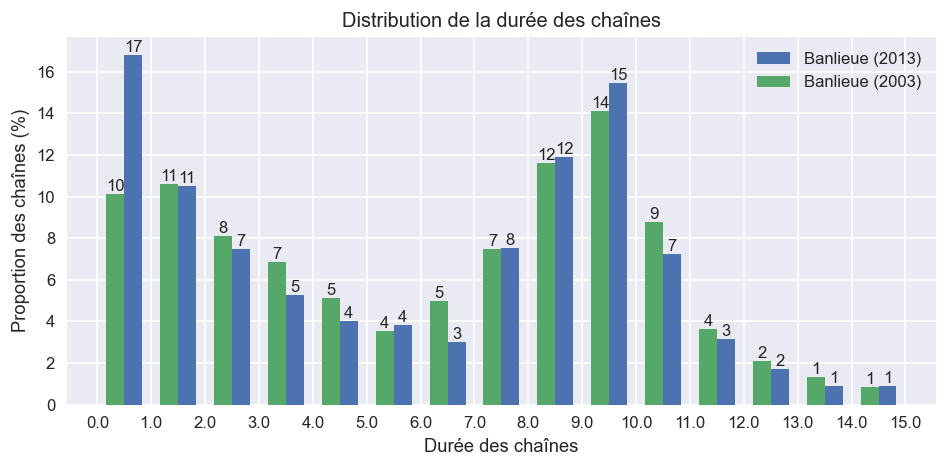

In [561]:
width = 20
plt.figure(figsize=(8, 4), dpi=120)
def length_plot(df, title, offset):
    df_chaine = df[df["f_chaine"] == 'T']

    total_facper = df_chaine.facper.sum()

    bin_edges = np.arange(0, 960, 60) # 0 to 900 minutes with 60 minute increments
    bins = np.histogram(list(df_chaine.ch_duree), bins=bin_edges, weights=df_chaine.facper / total_facper * 100)[0]

    print(len(bins))
    bar = plt.bar(bin_edges[:-1]+60/2-offset, bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f")

    _ = plt.xticks(bin_edges, bin_edges/60)
    plt.xlabel("Durée des chaînes")
    plt.ylabel("Proportion des chaînes (%)")
    plt.title("Distribution de la durée des chaînes")
length_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
length_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()




63.82704630705559
61.89061574187979


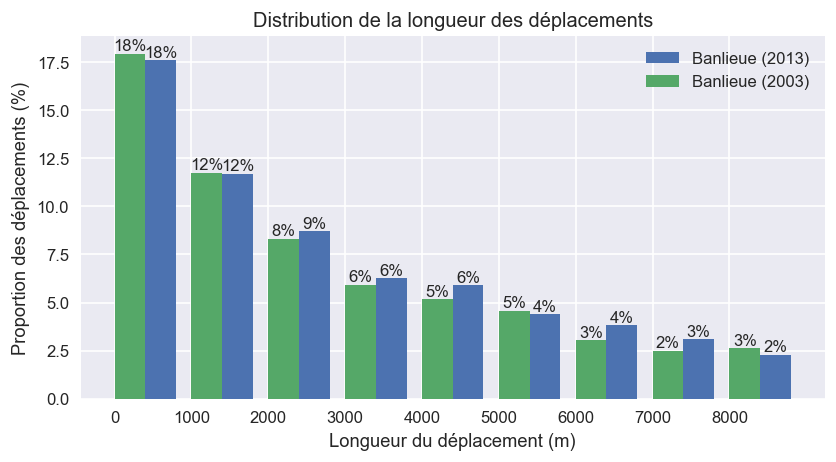

In [562]:
width = 400
plt.figure(figsize=(8, 4), dpi=120)
def dist_plot(df, title, offset):
    total_facper = df.facper.sum()

    bin_edges = np.arange(0, 10 * 1000, 1000)
    bins = np.histogram(list(df.distance_meters), bins=bin_edges, weights=df.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]+width-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Longueur du déplacement (m)")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution de la longueur des déplacements")
dist_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
dist_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()




349
205


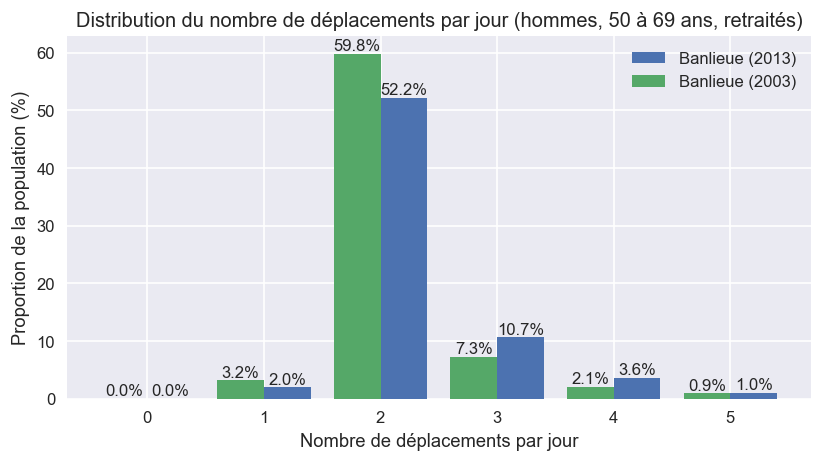

In [563]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def n_depl_plot(df, title, offset):
    df_pers = df[(df.f_pers == 'T')
               & (df.genre == 1) 
               & (df.age >= 50) 
               & (df.age <= 69)
               & (df.p_statut == 4)]
    print(len(df_pers))

    total_faclog = df_pers.facper.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_pers.nb_depl), bins=bin_edges, weights=df_pers.facper / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.1f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Nombre de déplacements par jour")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution du nombre de déplacements par jour (hommes, 50 à 69 ans, retraités)")
n_depl_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
n_depl_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()



# Tâche 3

In [649]:
combined_sect = pd.concat([suburb_2013, plateau, montrealNord])

132
91.8836240370164
220
92.47067041212843


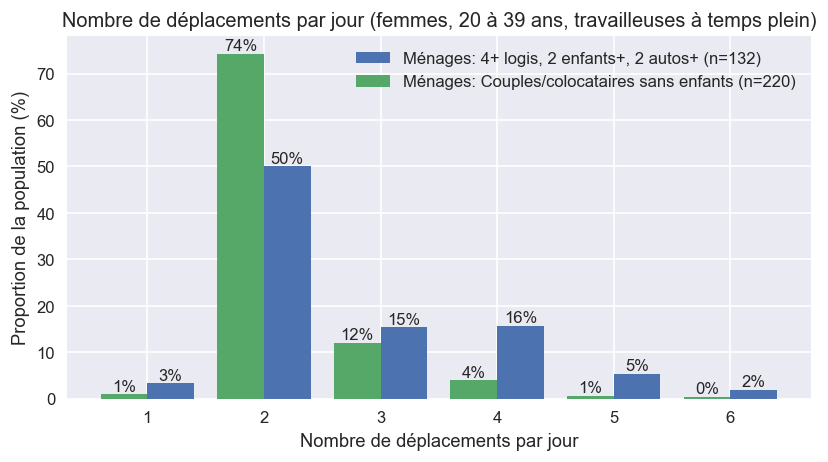

In [565]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def _n_depl_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    #df_pers = neighborhood_typology(df_pers, 4)
    #df_pers = menages_typology(df_pers, 3)
    print(len(df_pers))

    total_faclog = df_pers.facper.sum()

    bin_edges = np.array([1, 2, 3, 4, 5, 6, 7])
    bins = np.histogram(list(df_pers.nb_depl), bins=bin_edges, weights=df_pers.facper / total_faclog * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Nombre de déplacements par jour")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Nombre de déplacements par jour (femmes, 20 à 39 ans, travailleuses à temps plein)")
    #plt.title("Nombre de déplacements par jour (femmes, 20 à 39 ans, travailleuses à temps plein)\nMénages: Nb voitures = Nb conducteurs")
_n_depl_plot(menages_typology(combined_sect, 2), title="Ménages: 4+ logis, 2 enfants+, 2 autos+", offset=-width/2)
_n_depl_plot(menages_typology(combined_sect, 5), title="Ménages: Couples/colocataires sans enfants", offset=+width/2)
plt.legend()


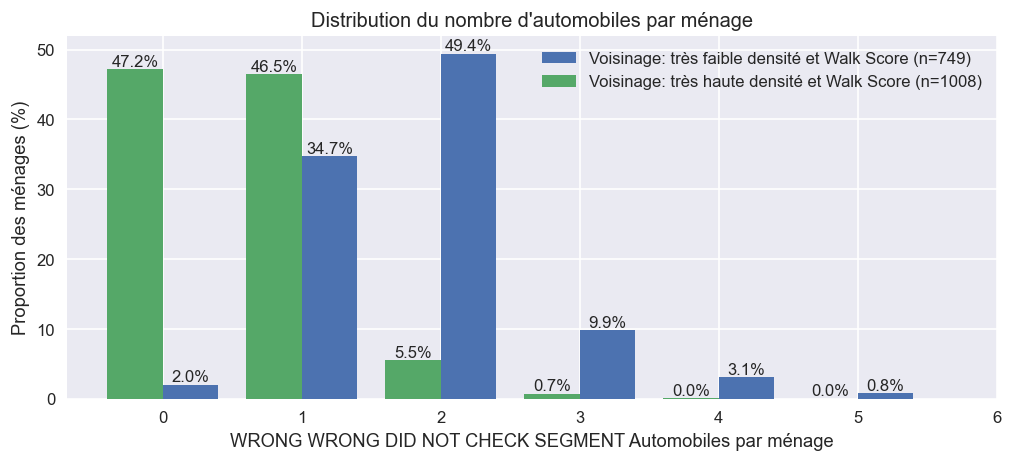

In [566]:
width = 0.4
plt.figure(figsize=(10, 4), dpi=120)
def __age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_households.autologi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]

    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title + f" (n={len(df_households)})")
    plt.bar_label(bar, fmt="%.1f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("WRONG WRONG DID NOT CHECK SEGMENT Automobiles par ménage")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par ménage")
__age_plot(neighborhood_typology(combined_sect, 1), title="Voisinage: très faible densité et Walk Score", offset=-width/2)
__age_plot(neighborhood_typology(combined_sect, 4), title="Voisinage: très haute densité et Walk Score", offset=+width/2)
plt.legend()


104it [00:00, 431.43it/s]
157it [00:00, 559.34it/s]


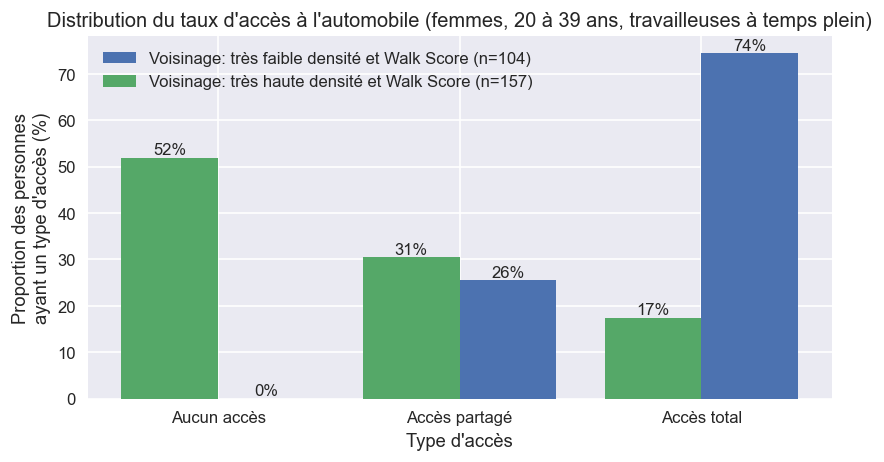

In [567]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def asd_age_plot(df_full, df, title, offset):
    df = pers_typology(df, 2) # Women, 20 to 39, workers
    df = df[df.f_pers == "T"]
    bins = [0, 0, 0]
    for i, row in tqdm.tqdm(df.iterrows()):
        household_row = df_full[(df_full["f_menage"] == 'T') & (df_full["feuillet"] == row.feuillet)]
        if household_row.drivers.item() == 0 or household_row.autologi.item() == 0:
            bins[0] += row.facper
        elif (household_row.autologi.item() / household_row.drivers.item()) > 0 and (household_row.autologi.item() / household_row.drivers.item()) < 1:
            bins[1] += row.facper
        elif (household_row.autologi.item() / household_row.drivers.item()) >= 1:
            bins[2] += row.facper
    
    bins = (np.array(bins) / df.facper.sum()) * 100
    
    bin_edges = np.array([0, 1, 2])
    bar = plt.bar(bin_edges-offset, bins, width=width, align="center", label=title + f" (n={len(df)})")
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges, ["Aucun accès", "Accès partagé", "Accès total"])
    plt.xlabel("Type d'accès")
    plt.ylabel("Proportion des personnes\nayant un type d'accès (%)")
    plt.title("Distribution du taux d'accès à l'automobile (femmes, 20 à 39 ans, travailleuses à temps plein)")
asd_age_plot(combined_sect, neighborhood_typology(combined_sect, 1), title="Voisinage: très faible densité et Walk Score", offset=-width/2)
asd_age_plot(combined_sect, neighborhood_typology(combined_sect, 4), title="Voisinage: très haute densité et Walk Score", offset=+width/2)
plt.legend()




104
92.05623696440806
157
97.84528569500138


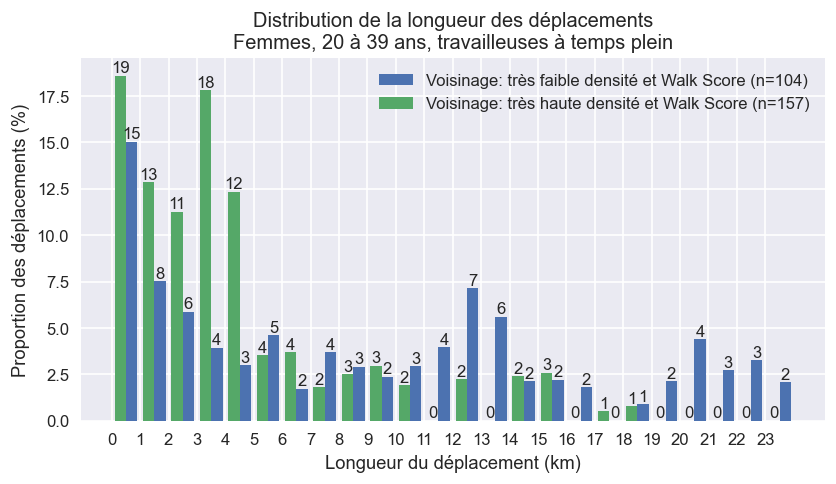

In [568]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def _n_dist_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    #df_pers = neighborhood_typology(df_pers, 4)
    #df_pers = menages_typology(df_pers, 3)
    print(len(df_pers))

    total_facper = df_pers.facper.sum()

    bin_edges = np.arange(0, 25, 1)
    bins = np.histogram(list(df_pers.distance_meters/1000), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]-offset+0.5, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
    #bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Longueur du déplacement (km)")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution de la longueur des déplacements\nFemmes, 20 à 39 ans, travailleuses à temps plein")
#_n_dist_plot(suburb_2013, title="Banlieue (2013)", offset=-width)
#_n_dist_plot(plateau, title="Le Plateau Mont-Royal (2013)", offset=0)
#_n_dist_plot(montrealNord, title="Montréal-Nord (2013)", offset=+width)
_n_dist_plot(neighborhood_typology(combined_sect, 1), title="Voisinage: très faible densité et Walk Score", offset=-width/2)
_n_dist_plot(neighborhood_typology(combined_sect, 4), title="Voisinage: très haute densité et Walk Score", offset=+width/2)
plt.legend()


104
157


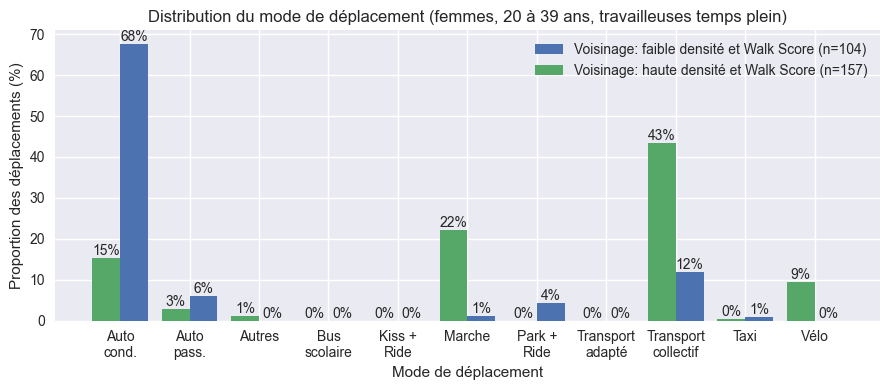

In [569]:
width = 0.4
plt.figure(figsize=(9, 4), dpi=100)
def _part3_mode_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    print(len(df_pers))

    total_facper = df_pers.facper.sum()

    modes_ = (df_pers.groupby("mode").sum()["facper"] / total_facper.sum() * 100)
    modes = []
    for mode in ["AC", "AP", "AUTRES", "BS", "KR", "MARCHE", "PR", "TA", "TC", "TX", "VELO"]:
        try:
            modes.append(modes_[mode])
        except KeyError:
            modes.append(0)
    modes = list(modes)
    xvals = np.arange(0, len(modes))
    bar = plt.bar(xvals-offset, modes, width=width, label=title + f" (n={len(df_pers)})")
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(xvals, ["Auto\ncond.",
                            "Auto\npass.",
                            "Autres", 
                            "Bus\nscolaire",
                            "Kiss +\nRide",
                            'Marche',
                            "Park +\nRide",
                            'Transport\nadapté', 
                            "Transport\ncollectif",
                            'Taxi', 
                            "Vélo",
                           ])
    plt.xlabel("Mode de déplacement")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution du mode de déplacement (femmes, 20 à 39 ans, travailleuses temps plein)")
_part3_mode_plot(neighborhood_typology(combined_sect, 1), title="Voisinage: faible densité et Walk Score", offset=-width/2)
_part3_mode_plot(neighborhood_typology(combined_sect, 4), title="Voisinage: haute densité et Walk Score", offset=+width/2)
plt.tight_layout()
plt.legend()

176
255


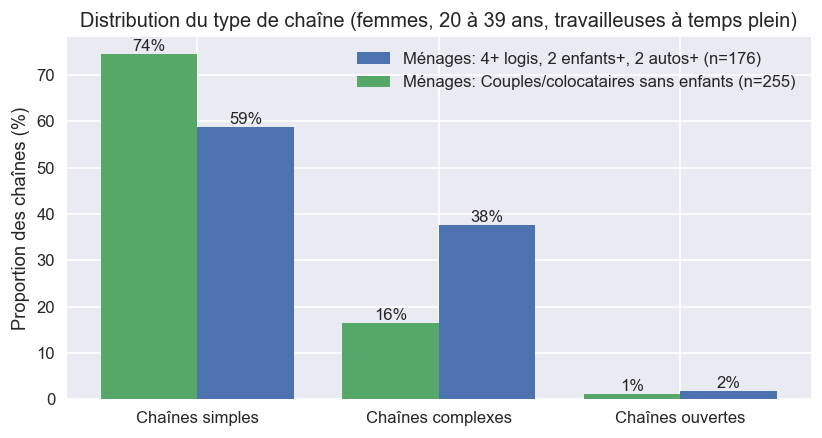

In [570]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def __n_dist_plot(df, title, offset):
    df_chaines = pers_typology(df, 2)
    df_chaines = df_chaines[df_chaines.f_chaine == "T"]
    print(len(df_chaines))

    total_facper = df_chaines.facper.sum()
    mono_facper = df_chaines[df_chaines.ch_type_simp == 1].facper.sum() / total_facper
    multi_facper = df_chaines[df_chaines.ch_type_comp == 1].facper.sum() / total_facper
    ouvertes = df_chaines[df_chaines.ch_type_ouv == 1].facper.sum() / total_facper

    bar = plt.bar([0-offset, 1-offset, 2-offset], [mono_facper*100, multi_facper*100, ouvertes*100], width=width, align="center", label=title + f" (n={len(df_chaines)})")
    #bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    plt.xticks([0, 1, 2], ["Chaînes simples", "Chaînes complexes", "Chaînes ouvertes"])
    #plt.xlabel("Type de chaîne")
    plt.ylabel("Proportion des chaînes (%)")
    plt.title("Distribution du type de chaîne (femmes, 20 à 39 ans, travailleuses à temps plein)")

__n_dist_plot(menages_typology(combined_sect, 2), title="Ménages: 4+ logis, 2 enfants+, 2 autos+", offset=-width/2)
__n_dist_plot(menages_typology(combined_sect, 5), title="Ménages: Couples/colocataires sans enfants", offset=+width/2)
plt.legend()



In [571]:
def calculate_drivers(df,title="ok"):
    df = pers_typology(df, 2)
    df = df[df.f_pers == "T"]
    total_facper = df.facper.sum()
    drivers = df[df.permis == 1].facper.sum()
    print(title, "n=", len(df), ",", round((drivers / total_facper) * 100, 2), "%")
calculate_drivers(menages_typology(combined_sect, 7), title="4+ logis, 2 enfants+")
calculate_drivers(menages_typology(combined_sect, 5), title="Couple ou colocataires sans enfants")

4+ logis, 2 enfants+ n= 234 , 93.14 %
Couple ou colocataires sans enfants n= 220 , 82.53 %


In [572]:
# width = 0.4
# plt.figure(figsize=(8, 4), dpi=120)
# def _n__dist_plot(df, title, offset):
#     df_pers = pers_typology(df, 2)
#     df_pers = df_pers[df_pers.f_chaine == "T"]
#     print(len(df_pers))

#     total_facper = df_pers.facper.sum()

#     bin_edges = np.arange(0, 12, 1)
#     bins = np.histogram(list(df_pers.ch_duree/60), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
#     print(sum(bins))
#     bar = plt.bar(bin_edges[:-1]-offset+0.5, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
#     #bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
#     plt.bar_label(bar, fmt="%.0f")
#     _ = plt.xticks(bin_edges[:-1])
#     plt.xlabel("Durée des chaînes (heures)")
#     plt.ylabel("Proportion des déplacements (%)")
#     plt.title("Distribution de la longueur des déplacements\nFemmes, 20 à 39 ans, travailleuses à temps plein")
# _n__dist_plot(menages_typology(combined_sect, 7), title="Voisinage: très faible densité et Walk Score", offset=-width/2)
# _n__dist_plot(menages_typology(combined_sect, 5), title="Voisinage: très haute densité et Walk Score", offset=+width/2)
# plt.legend()



475
585


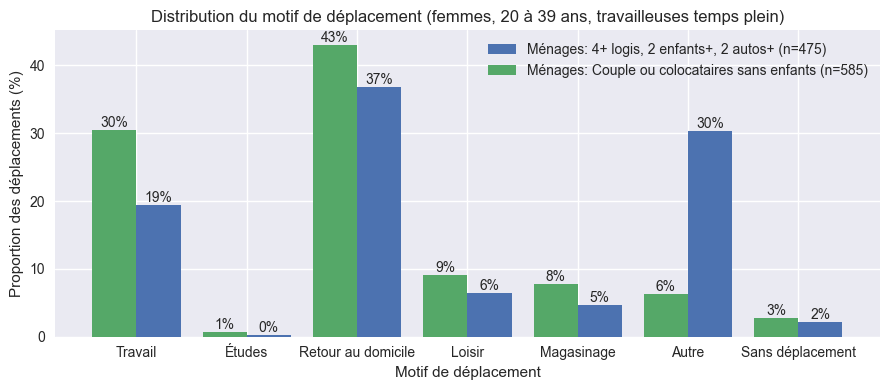

In [573]:
width = 0.4
plt.figure(figsize=(9, 4), dpi=100)
def _part3a_mode_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    #df_pers = df_pers[df_pers.f_pers == "T"]
    print(len(df_pers))

    total_facper = df_pers.facper.sum()

    motif = (df_pers.groupby("motif").sum()["facper"] / total_facper.sum() * 100)
    motif = list(motif)
    xvals = np.arange(0, len(motif))
    bar = plt.bar(xvals-offset, motif, width=width, label=title + f" (n={len(df_pers)})")
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(xvals, ["Travail",
                           "Études",
                           "Retour au domicile",
                           "Loisir",
                           "Magasinage",
                           "Autre",
                           "Sans déplacement"
                           ])
    plt.xlabel("Motif de déplacement")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution du motif de déplacement (femmes, 20 à 39 ans, travailleuses temps plein)")
_part3a_mode_plot(menages_typology(combined_sect, 2), title="Ménages: 4+ logis, 2 enfants+, 2 autos+", offset=-width/2)
_part3a_mode_plot(menages_typology(combined_sect, 5), title="Ménages: Couple ou colocataires sans enfants", offset=+width/2)
plt.tight_layout()
plt.legend()

## Espaces d'activité

132
85.58735726877325
220
94.4390103533938


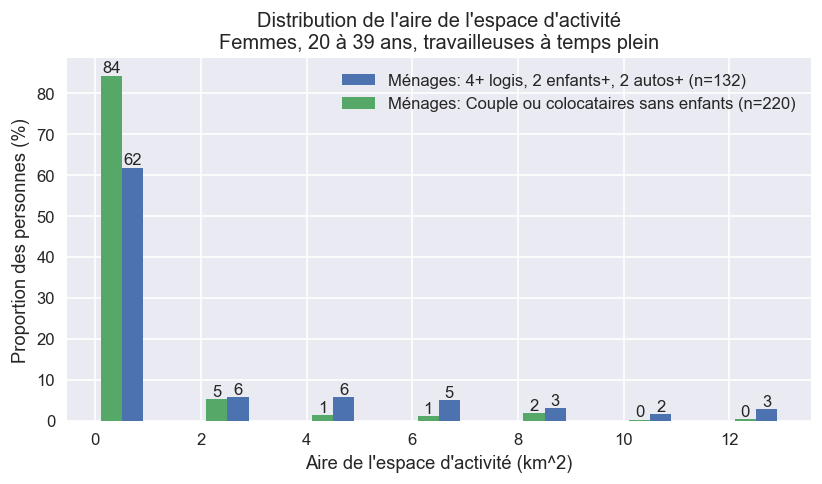

In [675]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def _part3a_mode_plot__(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    print(len(df_pers))

    total_facper = df_pers.facper.sum()

    bin_edges = np.arange(0, 15, 2)
    bins = np.histogram(list(df_pers.ch_area * 1e-6), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]-offset+0.5, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
    #bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Aire de l'espace d'activité (km^2)")
    plt.ylabel("Proportion des personnes (%)")
    plt.title("Distribution de l'aire de l'espace d'activité\nFemmes, 20 à 39 ans, travailleuses à temps plein")
_part3a_mode_plot__(menages_typology(combined_sect, 2), title="Ménages: 4+ logis, 2 enfants+, 2 autos+", offset=-width/2)
_part3a_mode_plot__(menages_typology(combined_sect, 5), title="Ménages: Couple ou colocataires sans enfants", offset=+width/2)
plt.legend()



92.90706635839378
95.97212021214999


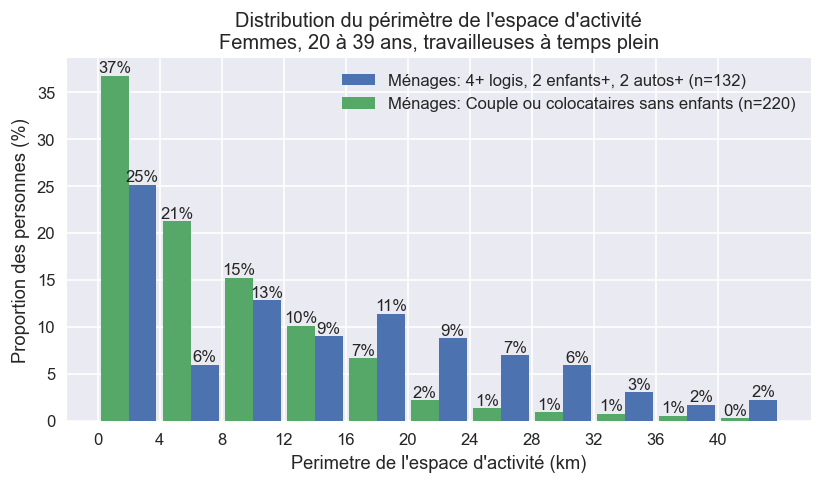

In [687]:
width = 1.8
plt.figure(figsize=(8, 4), dpi=120)
def _part3aaa_mode_plot__(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]

    total_facper = df_pers.facper.sum()

    bin_edges = np.arange(0, 45, 4)
    bins = np.histogram(list(df_pers.ch_perimeter * 1e-3), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]-offset+2, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Perimetre de l'espace d'activité (km)")
    plt.ylabel("Proportion des personnes (%)")
    plt.title("Distribution du périmètre de l'espace d'activité\nFemmes, 20 à 39 ans, travailleuses à temps plein")
_part3aaa_mode_plot__(menages_typology(combined_sect, 2), title="Ménages: 4+ logis, 2 enfants+, 2 autos+", offset=-width/2)
_part3aaa_mode_plot__(menages_typology(combined_sect, 5), title="Ménages: Couple ou colocataires sans enfants", offset=+width/2)
plt.legend()

91.58319280235662
97.93521597526822


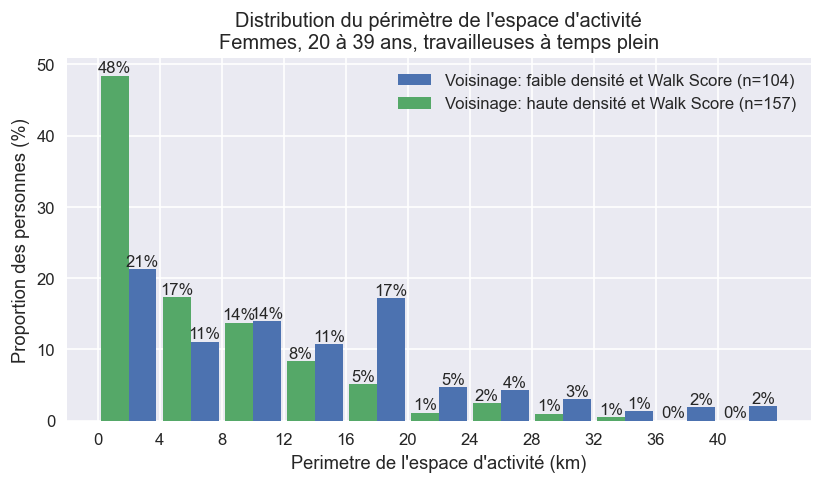

In [688]:
width = 1.8
plt.figure(figsize=(8, 4), dpi=120)
def _part3aa_mode_plot__(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]

    total_facper = df_pers.facper.sum()

    bin_edges = np.arange(0, 45, 4)
    bins = np.histogram(list(df_pers.ch_perimeter * 1e-3), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]-offset+2, bins, width=width, align="center", label=title + f" (n={len(df_pers)})")
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Perimetre de l'espace d'activité (km)")
    plt.ylabel("Proportion des personnes (%)")
    plt.title("Distribution du périmètre de l'espace d'activité\nFemmes, 20 à 39 ans, travailleuses à temps plein")
_part3aa_mode_plot__(neighborhood_typology(combined_sect, 1), title="Voisinage: faible densité et Walk Score", offset=-width/2)
_part3aa_mode_plot__(neighborhood_typology(combined_sect, 4), title="Voisinage: haute densité et Walk Score", offset=+width/2)
plt.legend()